## CESM2 - LARGE ENSEMBLE (LENS2)

- This Notebooks intends to compute the heat balance in the South Atlantic, defined by the difference of the meridional heat transport from the northern and southern boundaries and the total heat surface heat (area integral). 

### Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np 
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cmocean

### Dask

In [2]:
mem_per_worker = 30 # memory per worker in GB 
num_workers = 26 # number of workers
cluster = NCARCluster(cores=1, processes=1, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=1:mem={mem_per_worker}GB', walltime='6:00:00')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46093 instead
  warnings.warn(


<Client: 'tcp://10.12.206.51:34520' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/46093/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/46093/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:34520,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/46093/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['N_HEAT','SHF','TEMP','TEND_TEMP'],frequency='month_1')

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={'consolidated': True}, storage_options={'anon': True})
print(f'\nDataset dictionary keys:\n {dset_dict_raw.keys()}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.cmip6.TEND_TEMP', 'ocn.historical.pop.h.smbb.N_HEAT', 'ocn.historical.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.cmip6.SHF', 'ocn.ssp370.pop.h.smbb.TEND_TEMP', 'ocn.ssp370.pop.h.smbb.N_HEAT', 'ocn.historical.pop.h.cmip6.N_HEAT', 'ocn.ssp370.pop.h.cmip6.TEMP', 'ocn.ssp370.pop.h.cmip6.SHF', 'ocn.ssp370.pop.h.cmip6.TEND_TEMP', 'ocn.ssp370.pop.h.cmip6.N_HEAT', 'ocn.historical.pop.h.smbb.SHF', 'ocn.ssp370.pop.h.smbb.SHF', 'ocn.historical.pop.h.smbb.TEND_TEMP', 'ocn.ssp370.pop.h.smbb.TEMP', 'ocn.historical.pop.h.smbb.TEMP'])


#### Variables

In [117]:
fb=(['N_HEAT','SHF','TEMP','TEND_TEMP']) # Meridional heat transport [PW], total surface heat flux [W/m2], and temperature [oC]
pd=('historical','ssp370') # periods
ff=('cmip6','smbb') # forcing
for ifb in range(0,len(fb)):
    for iff in range(0,len(ff)):
        for ipd in range(0,len(pd)):
            str=f'ds_{pd[ipd]}_{ff[iff]}_{fb[ifb]} = dset_dict_raw[\'ocn.{pd[ipd]}.pop.h.{ff[iff]}.{fb[ifb]}\']'
            exec(str)
        str=f'ds_{ff[iff]}_{fb[ifb]}=xr.combine_nested([ds_{pd[0]}_{ff[iff]}_{fb[ifb]},ds_{pd[1]}_{ff[iff]}_{fb[ifb]}],concat_dim=[\'time\']);'
        exec(str)
    str=f'ds_{fb[ifb]}=xr.combine_nested([ds_{ff[0]}_{fb[ifb]},ds_{ff[1]}_{fb[ifb]}],concat_dim=[\'member_id\']);'
    exec(str) 
print(f'Done!')

Done!


#### Import POP grid

In [118]:
pop_grid = pop_tools.get_grid('POP_gx1v7')
ds_SHF['TLONG'] = pop_grid.TLONG; ds_SHF['TLAT'] = pop_grid.TLAT
ds_TEMP['TLONG'] = pop_grid.TLONG; ds_TEMP['TLAT'] = pop_grid.TLAT
ds_TEND_TEMP['TLONG'] = pop_grid.TLONG; ds_TEND_TEMP['TLAT'] = pop_grid.TLAT

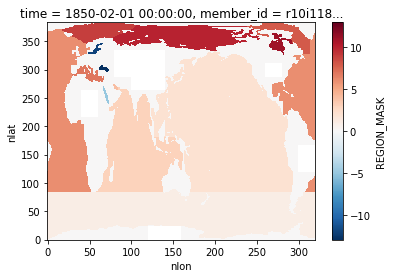

In [119]:
## Define the MOC region mask:
rmask = ds_N_HEAT.REGION_MASK.drop(['ULONG','ULAT'])
rmask.isel(member_id=0,time=0).plot()

#### Calculate the difference in heat transport to latitudes closer to the equator and 34S. We chose 34 instead of 34.5S, because at 34S we are sure that there is no water leakage south of Africa 

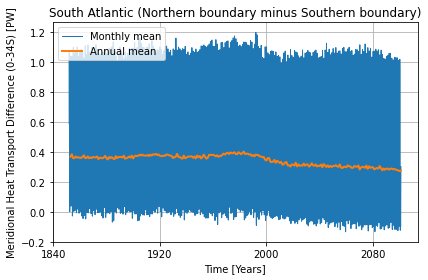

In [120]:
ilan = 0 # northernmost latitude
ilas = -34 # southernmost latitude

ds_N_HEAT_diff=((ds_N_HEAT.N_HEAT.isel(transport_reg=1).sel(lat_aux_grid=ilan,method='nearest'))-(ds_N_HEAT.N_HEAT.isel(transport_reg=1).sel(lat_aux_grid=ilas,method='nearest'))).sum(dim='transport_comp')
ds_N_HEAT_diff
ds_N_HEAT_diff.sel(time=slice('1852-01-01','2100-12-31')).mean(dim='member_id').plot(linewidth=1,label='Monthly mean')
ds_N_HEAT_diff.sel(time=slice('1852-01-01','2100-12-31')).mean(dim='member_id').resample(time='1Y',closed='left').mean('time').plot(linewidth=2, label='Annual mean')
plt.grid()
plt.title('South Atlantic (Northern boundary minus Southern boundary)')
plt.xlabel('Time [Years]')
plt.ylabel('Meridional Heat Transport Difference (0-34S) [PW]')
plt.legend()
plt.tight_layout()
plt.show()

#### Select the area to compute the heat balance

In [177]:
dask.config.set({"array.slicing.split_large_chunks": True})
ilon1, flon1, ilon2, flon2 = 307, 320, 0, 54 # longitude (initial, final) 
fb=(['SHF','TEMP','TEND_TEMP'])
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    st=f'sa_ds_{fb[ifb]}=xr.combine_nested([[ds_{fb[ifb]}.{fb[ifb]}.where((ds_{fb[ifb]}.{fb[ifb]}.ULAT >= ilas) & (ds_{fb[ifb]}.{fb[ifb]}.ULAT <= ilan), drop=True).isel(nlon = slice(ilon1,flon1)),ds_{fb[ifb]}.{fb[ifb]}.where((ds_{fb[ifb]}.{fb[ifb]}.ULAT >= ilas) & (ds_{fb[ifb]}.{fb[ifb]}.ULAT <= ilan), drop=True).isel(nlon = slice(ilon2,flon2))]],concat_dim=[\'nlat\',\'nlon\'])'; exec(st)
    st=f'sa_ds_{fb[ifb]}.coords[\'nlon\'] = (sa_ds_{fb[ifb]}.coords[\'nlon\'] + 180) % 360 - 180'; exec(st) 
    st=f'sa_ds_{fb[ifb]} = sa_ds_{fb[ifb]}.sortby(sa_ds_{fb[ifb]}.nlon)'; exec(st)

Variable: SHF
Variable: TEMP
Variable: TEND_TEMP


In [181]:
sa_ds_dz=ds_TEMP.dz*0.01 # cm to m

### Recreate the area for the temperature mask

In [228]:
# Area in cm2
sa_ds_UAREA=xr.combine_nested(
    [[pop_grid.UAREA.where((pop_grid.ULAT >= ilas) & (pop_grid.ULAT <= ilan), drop=True).isel(nlon = slice(ilon1,flon1)),
      pop_grid.UAREA.where((pop_grid.ULAT >= ilas) & (pop_grid.ULAT <= ilan), drop=True).isel(nlon = slice(ilon2,flon2))]],
                           concat_dim=['nlat','nlon'])
sa_ds_UAREA.coords['nlon'] = (sa_ds_UAREA.coords['nlon'] + 180) % 360 - 180 
sa_ds_UAREA = sa_ds_UAREA.sortby(sa_ds_UAREA.nlon)

In [231]:
mask_ocean_TEMP = 2 * np.ones((len(sa_ds_TEMP.coords['nlat']), len(sa_ds_TEMP.coords['nlon']))) * np.isfinite(sa_ds_TEMP.isel(time=0,member_id=0))  
mask_land_TEMP = 1 * np.ones((len(sa_ds_TEMP.coords['nlat']), len(sa_ds_TEMP.coords['nlon']))) * np.isnan(sa_ds_TEMP.isel(time=0,member_id=0))  
mask_array_TEMP = mask_ocean_TEMP + mask_land_TEMP      

In [236]:
area_new=sa_ds_UAREA.where(mask_array_TEMP != 0.) # Applying the basin masks in the area

#            st=f'area_new=np.array([area_new]*len({ba[iba]}_{fb[ifb]}.coords[\'z_t\']))'; exec(st) # Replicating the surface area for all as depths
#            st=f'area_array=xr.DataArray(area_new, dims=[\'z_t\', \'nlat\', \'nlon\'])'; exec(st) # We transform the array into a xarray so that there are no mismatches in the oprerations
#            st=f'area_array_{ba[iba]}_{fb[ifb]}=area_array.where(mask_array_{ba[iba]}_{fb[ifb]} != 1.)'; exec(st) # The masks of what is ocean and what is continent or floor were built
        

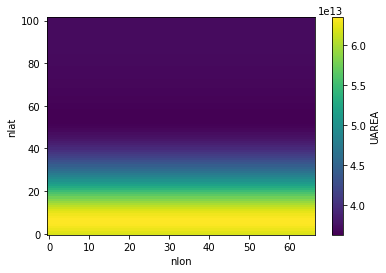

In [242]:
sa_ds_UAREA.plot()

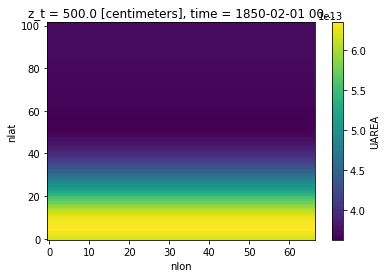

In [240]:
area_new.isel(z_t=0).plot()

In [ ]:
mask_array_TEMP.shape

In [ ]:
mask_SHF = sa_ds_SHF.isel(time=2, member_id=0).fillna(9999)
area_sa=area_sa.where(mask_SHF != 9999.)

In [ ]:
Total_SHF=(sa_ds_SHF*area_sa*1e-4*1e-15).sum(dim=['nlat','nlon'],skipna=True) # Units PW 

##### Here it was necessary to do the difference and not the sum of the terms to get the heat balance. This is because the SHF convection is positive to the ocean. The balance is given by every heat flux entering from the surface (positive direction of the z-axis) is equal to every flux leaving from the meridional heat transport (positive direction of the y-axis). The meirdional heat transport has a positive y-axis direction, but the SHF has not a negative z-axis direction. 

In [ ]:
SHF_MHT_diff=Total_SHF-ds_N_HEAT_diff 

In [ ]:
sa_ds_dz['z_t']=sa_ds_dz['z_t']*0.01
sa_ds_TEMP['z_t']=sa_ds_TEMP['z_t']*0.01

In [ ]:
sa_ds_TEMP.isel(member_id=0,time=0, z_t=0).plot()

#### To know if our heat balance is correct, let's calculate the heat storage and compare it with the difference found 
#### The formula for this is: $$\rm{HS = \uprho_\uptheta~C_p~\int_{z_2}^{z_1}\uptheta_{(z)}'~dz},$$
where:
* HS is heat storage ($\rm{J~m^{-2}}$),
* $\uprho$ is the density of sea water, 1026 $\rm{kg~m^{-3}}$,
* $\rm{C_p}$ is the specific heat of sea water, 3996 $\rm{J~kg^{-1}~K^{-1}}$ from the model
* $\rm{z}$ is the depth limit on the calculation in meters,
* and $\uptheta$' is the potential temperature monthly anomaly (successor month minus previous month) at each depth in degress Kelvin. 

In [ ]:
rho = 1026 # kg/m^3
c_p = 3996 # J/(kg K) - I used the same amount of specific heat used by the model
sa_ds_TEMP_anom=sa_ds_TEMP.diff(dim='time') # oC

In [ ]:
%%time
sa_ds_HS=((sa_ds_TEMP_anom.mean(dim='member_id')*sa_ds_dz.mean(dim='member_id')).sum(dim='z_t'))*rho*c_p # J m-2
sa_ds_HS=sa_ds_HS.where(mask_SHF != 9999.).load()
sa_ds_HS.mean(dim='time').plot()

In [ ]:
sa_ds_HS=(sa_ds_HS*area_sa*1e-4).sum(dim=['nlon','nlat']) # J

In [ ]:
%%time
# Selecting the number of days each month has
dt = np.empty((len(ds_N_HEAT.time_bound.coords['time']))) * np.nan
for it in range(0,len(ds_N_HEAT.time_bound.coords['time'])):
    dt[it]=np.abs(ds_N_HEAT.time_bound.isel(member_id=0,time=it,d2=0).values-ds_N_HEAT.time_bound.isel(member_id=0,time=it,d2=1).values).days

In [ ]:
# 1 month = 60*60*24s
# 1 W = 1e-15 PW
sa_ds_HS_PW=sa_ds_HS*(1e-15)/(60*60*24*dt[0:-1]) # PW 

In [ ]:
%%time
Total_SHF=Total_SHF.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))
ds_N_HEAT_diff=ds_N_HEAT_diff.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))*-1
SHF_MHT_diff=SHF_MHT_diff.mean(dim='member_id').resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))
sa_ds_HS_PW=sa_ds_HS_PW.resample(time='1Y',closed='left').mean('time').sel(time=slice('1851-01-01','2100-12-31'))

In [ ]:
plt.figure(figsize=(14, 6))
Total_SHF.plot(linewidth=1, label='SHF')
ds_N_HEAT_diff.plot(linewidth=1, label='MHT')
SHF_MHT_diff.plot(linewidth=1,label='SHF+MHT')
sa_ds_HS_PW.plot(linewidth=1,label='HS')
plt.title('South Atlantic Ocean')
plt.xlabel('Time [Years]')
plt.ylabel('Annual average heat balance [PW]')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
Total_SHF

In [ ]:
# Normalized
plt.figure(figsize=(14, 6))
((Total_SHF-np.min(Total_SHF))/(np.max(Total_SHF)-np.min(Total_SHF))).plot(linewidth=1, label='SHF')
((ds_N_HEAT_diff-np.min(ds_N_HEAT_diff))/(np.max(ds_N_HEAT_diff)-np.min(ds_N_HEAT_diff))).plot(linewidth=1, label='MHT')
((SHF_MHT_diff-np.min(SHF_MHT_diff))/(np.max(SHF_MHT_diff)-np.min(SHF_MHT_diff))).plot(linewidth=1, label='SHF+MHT')
((sa_ds_HS_PW-np.min(sa_ds_HS_PW))/(np.max(sa_ds_HS_PW)-np.min(sa_ds_HS_PW))).plot(linewidth=1, label='HS')
plt.xlabel('Time [Years]')
plt.ylabel('Annual average heat balance [PW]')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

### Concluding remarks
- According to Hu_etal_JC_2020 (https://drive.google.com/drive/u/0/folders/1yEZXkt1xDH2nOxIHXXs0EL1WbDD8BvmA), the oceans absorb excess heat from the atmosphere at high latitudes (subpolar divergences) and store this heat in the tropics. That may be the mechanism that explains why the SHF has no trend in the SSP370 scenario
- For the historical, the SHF seems to control the HS variability. For the ssp370, the MHT gains importance not only in the amount of HS but also in its variability

### What are the next steps?
- Write about the heat balance in the South Atlantic (chapter)
- Split the SHF into long-wave radiation, incident solar radiation, latent heat flux, and sensible heat flux
- Split the MHT into Vdt and TdV (see Hu_etal_JC_2020)
- Compute the contribution of SHF and MHT to HS variability 
### Questions: 
- Is it necessary to validate the MHT and SHF? If so, which dataset can we analyze? Dr. Shenfu Dong shared the MHT calculated from altimeters for the four latitudes: 20S, 25S, 30S, 34.5S